In [2]:
import math
import numpy as np

# method 1: absSum
def calVolume(waveData, frameSize, overLap):
    wlen = len(waveData)
    step = frameSize - overLap
    frameNum = int(math.ceil(wlen*1.0/step))
    volume = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = waveData[np.arange(i*step,min(i*step+frameSize,wlen))]
        #curFrame = curFrame - np.median(curFrame) # False
        curFrame = curFrame - np.mean(curFrame) # zero-justified
        volume[i] = np.sum(np.abs(curFrame))
    return volume

# method 2: log10 of square sum
def calVolumeDB(waveData, frameSize, overLap):
    wlen = len(waveData)
    step = frameSize - overLap
    frameNum = int(math.ceil(wlen*1.0/step))
    volume = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = waveData[np.arange(i*step,min(i*step+frameSize,wlen))]
        curFrame = curFrame - np.mean(curFrame) # zero-justified
        volume[i] = 10*np.log10(np.sum(curFrame*curFrame))
    return volume


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


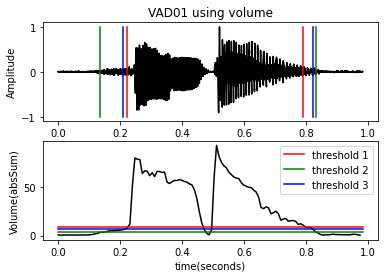

In [3]:
import wave
import numpy as np
import matplotlib.pyplot as plt
import Volume as vp

def findIndex(vol,thres):
    l = len(vol)
    ii = 0
    index = np.zeros(4,dtype=np.int16)
    for i in range(l-1):
        if((vol[i]-thres)*(vol[i+1]-thres)<0):
            index[ii]=i
            ii = ii+1
    return index[[0,-1]]

fw = wave.open('/content/sunday.wav','r')
params = fw.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
strData = fw.readframes(nframes)
waveData = np.fromstring(strData, dtype=np.int16)
waveData = waveData*1.0/max(abs(waveData))  # normalization
fw.close()

frameSize = 256
overLap = 128
vol = vp.calVolume(waveData,frameSize,overLap)
threshold1 = max(vol)*0.10
threshold2 = min(vol)*10.0
threshold3 = max(vol)*0.05+min(vol)*5.0

time = np.arange(0,nframes) * (1.0/framerate)
vols = np.arange(0,len(vol)) * (nframes*1.0/len(vol)/framerate)
index1 = findIndex(vol,threshold1)*(nframes*1.0/len(vol)/framerate)
index2 = findIndex(vol,threshold2)*(nframes*1.0/len(vol)/framerate)
index3 = findIndex(vol,threshold3)*(nframes*1.0/len(vol)/framerate)
end = nframes * (1.0/framerate)

plt.subplot(211)
plt.title("VAD01 using volume")
plt.plot(time,waveData,color="black")
plt.plot([index1,index1],[-1,1],'-r')
plt.plot([index2,index2],[-1,1],'-g')
plt.plot([index3,index3],[-1,1],'-b')
plt.ylabel('Amplitude')

plt.subplot(212)
plt.plot(vols,vol,color="black")
plt.plot([0,end],[threshold1,threshold1],'-r', label="threshold 1")
plt.plot([0,end],[threshold2,threshold2],'-g', label="threshold 2")
plt.plot([0,end],[threshold3,threshold3],'-b', label="threshold 3")
plt.legend()
plt.ylabel('Volume(absSum)')
plt.xlabel('time(seconds)')
plt.savefig("VAD01")
plt.show()


In [4]:
import math
import numpy as np

def ZeroCR(waveData,frameSize,overLap):
    wlen = len(waveData)
    step = frameSize - overLap
    frameNum = int(math.ceil(wlen*1.0/step))
    zcr = np.zeros((frameNum,1))
    for i in range(frameNum):
        curFrame = waveData[np.arange(i*step, min(i*step+frameSize,wlen))]
        #To avoid DC bias, usually we need to perform mean subtraction on each frame
        curFrame = curFrame - np.mean(curFrame) # zero-justified
        zcr[i] = sum(curFrame[0:-1]*curFrame[1:]<=0)
    return zcr

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=15891, comptype='NONE', compname='not compressed')
145.45454545454547


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


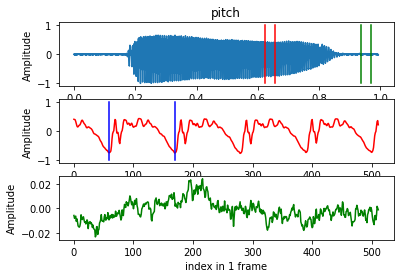

In [6]:
import wave
import numpy as np
import pylab as pl

# read wave file and get parameters.
fw = wave.open('/content/a.wav','rb')
params = fw.getparams()
print(params)
nchannels, sampwidth, framerate, nframes = params[:4]
strData = fw.readframes(nframes)
waveData = np.fromstring(strData, dtype=np.int16)
waveData = waveData*1.0/max(abs(waveData))  # normalization
fw.close()

# plot the wave
time = np.arange(0, len(waveData)) * (1.0 / framerate)

index1 = 10000.0 / framerate
index2 = 10512.0 / framerate
index3 = 15000.0 / framerate
index4 = 15512.0 / framerate

pl.subplot(311)
pl.title("pitch")
pl.plot(time, waveData)
pl.plot([index1,index1],[-1,1],'r')
pl.plot([index2,index2],[-1,1],'r')
pl.plot([index3,index3],[-1,1],'g')
pl.plot([index4,index4],[-1,1],'g')
pl.xlabel("time (seconds)")
pl.ylabel("Amplitude")

pl.subplot(312)
pl.plot(np.arange(512),waveData[10000:10512],'r')
pl.plot([59,59],[-1,1],'b')
pl.plot([169,169],[-1,1],'b')
print(1/( (169-59)*1.0/framerate ))
pl.xlabel("index in 1 frame")
pl.ylabel("Amplitude")

pl.subplot(313)
pl.plot(np.arange(512),waveData[15000:15512],'g')
pl.xlabel("index in 1 frame")
pl.ylabel("Amplitude")
pl.savefig("pitch.png")
pl.show()

In [7]:
import math
import numpy as np

# Orignal auto-correlation function(ACF)
def ACF(frame):
    flen = len(frame)
    acf = np.zeros(flen)
    for i in range(flen):
        acf[i] = np.sum(frame[i:flen]*frame[0:flen-i])
    return acf

# ACF with weight
def ACF2(frame):
    flen = len(frame)
    acf = np.zeros(flen)
    for i in range(flen):
        acf[i] = np.sum(frame[i:flen]*frame[0:flen-i])/(flen-i)
    return acf

# ACF to half frame length
def ACF3(frame):
    flen = len(frame)
    acf = np.zeros(flen/2)
    for i in range(flen/2):
        acf[i] = np.sum(frame[i:flen]*frame[0:flen-i])
    return acf

# normalized squared difference function(NSDF)
def NSDF(frame):
    flen = len(frame)
    nsdf = np.zeros(flen)
    for i in range(flen):
        s1 = np.sum(frame[i:flen]*frame[0:flen-i])
        s2 = np.sum(frame[i:flen]*frame[i:flen])
        s3 = np.sum(frame[0:flen-i]*frame[0:flen-i])
        nsdf[i] = 2.0*s1/(s2+s3)
    return nsdf

# AMDF (average magnitude difference function) 
def AMDF(frame):
    flen = len(frame)
    amdf = np.zeros(flen)
    for i in range(flen):
        amdf[i] = -np.sum(np.abs(frame[i:flen]-frame[0:flen-i]))  # to adjust to ACF, I use the -AMDF
    return amdf

# AMDF with weight
def AMDF2(frame):
    flen = len(frame)
    amdf = np.zeros(flen)
    for i in range(flen):
        amdf[i] = -np.sum(np.abs(frame[i:flen]-frame[0:flen-i]))/(flen-i)  # to adjust to ACF, I use the -AMDF
    return amdf

# AMDF to half frame length
def AMDF3(frame):
    flen = len(frame)
    amdf = np.zeros(flen/2)
    for i in range(flen/2):
        amdf[i] = -np.sum(np.abs(frame[i:flen]-frame[0:flen-i]))  # to adjust to ACF, I use the -AMDF
    return amdf

# Pitch Tracking
def PitchTrack(waveData,frameRate,frameSize,overLap,acfmethod):
    wlen = len(waveData)
    step = frameSize - overLap
    frameNum = int(math.ceil(wlen*1.0/step))
    pitchtrack = np.zeros(frameNum)
    for i in range(frameNum):
        #acf = acfmethod(waveData[i*step : i*step+frameSize])  # Bug
        acf = acfmethod(waveData[int(i*step):int(i*step+frameSize)])
        acf[0:30] = np.min(acf)
        acfmax = np.argmax(acf)
        pitchtrack[i] = frameRate*1.0/acfmax
    return pitchtrack


_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=85392, comptype='NONE', compname='not compressed')
110
145.45454545454547


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if sys.path[0] == '':


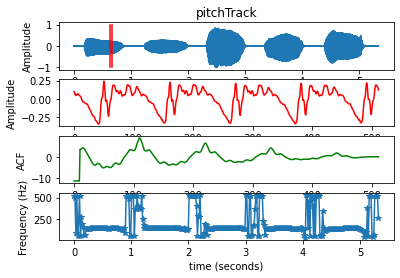

In [9]:
import wave
import numpy as np
import pylab as pl
import PitchTracking as pt

# read wave file and get parameters.
fw = wave.open('/content/aeiou.wav','rb')
params = fw.getparams()
print(params)
nchannels, sampwidth, framerate, nframes = params[:4]
strData = fw.readframes(nframes)
waveData = np.fromstring(strData, dtype=np.int16)
waveData = waveData*1.0/max(abs(waveData))  # normalization
fw.close()

# plot the wave
time = np.arange(0, len(waveData)) * (1.0 / framerate)

frameSize = 512
overLap = frameSize/2
idx1 = 10000
idx2 = idx1+frameSize
index1 = idx1*1.0 / framerate
index2 = idx2*1.0 / framerate
acf = pt.ACF(waveData[idx1:idx2])
acf[0:10] = -acf[0]
acfmax = np.argmax(acf)
print(acfmax)
print(framerate*1.0/acfmax)

pl.subplot(411)
pl.title("pitchTrack")
pl.plot(time, waveData)
pl.plot([index1,index1],[-1,1],'r')
pl.plot([index2,index2],[-1,1],'r')
pl.xlabel("time (seconds)")
pl.ylabel("Amplitude")

pl.subplot(412)
pl.plot(np.arange(frameSize),waveData[idx1:idx2],'r')
pl.xlabel("index in 1 frame")
pl.ylabel("Amplitude")

pl.subplot(413)
pl.plot(np.arange(frameSize),acf,'g')
pl.xlabel("index in 1 frame")
pl.ylabel("ACF")

# pitch tracking
acfmethod = pt.ACF
pitchtrack = pt.PitchTrack(waveData, framerate, frameSize, overLap, acfmethod)
xpt = np.arange(0, len(pitchtrack)) *( len(waveData) *1.0/ len(pitchtrack) / framerate )
pl.subplot(414)
pl.plot(xpt,pitchtrack,'-*')
pl.xlabel('time (seconds)')
pl.ylabel('Frequency (Hz)')

#pl.savefig("pitchTrack.png")
pl.show()

In [10]:
from __future__ import division
import numpy
import sigproc
from scipy.fftpack import dct

def mfcc(signal,samplerate=16000,winlen=0.025,winstep=0.01,numcep=13,
         nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,ceplifter=22,appendEnergy=True,
         winfunc=lambda x:numpy.ones((x,))):
   
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph,winfunc)
    feat = numpy.log(feat)
    feat = dct(feat, type=2, axis=1, norm='ortho')[:,:numcep]
    feat = lifter(feat,ceplifter)
    if appendEnergy: feat[:,0] = numpy.log(energy) # replace first cepstral coefficient with log of frame energy
    return feat

def fbank(signal,samplerate=16000,winlen=0.025,winstep=0.01,
          nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
          winfunc=lambda x:numpy.ones((x,))):
    
    highfreq= highfreq or samplerate/2
    signal = sigproc.preemphasis(signal,preemph)
    frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)
    pspec = sigproc.powspec(frames,nfft)
    energy = numpy.sum(pspec,1) # this stores the total energy in each frame
    energy = numpy.where(energy == 0,numpy.finfo(float).eps,energy) # if energy is zero, we get problems with log

    fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)
    feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
    feat = numpy.where(feat == 0,numpy.finfo(float).eps,feat) # if feat is zero, we get problems with log

    return feat,energy

def logfbank(signal,samplerate=16000,winlen=0.025,winstep=0.01,
          nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97):
  
    feat,energy = fbank(signal,samplerate,winlen,winstep,nfilt,nfft,lowfreq,highfreq,preemph)
    return numpy.log(feat)

def ssc(signal,samplerate=16000,winlen=0.025,winstep=0.01,
        nfilt=26,nfft=512,lowfreq=0,highfreq=None,preemph=0.97,
        winfunc=lambda x:numpy.ones((x,))):
  
    highfreq= highfreq or samplerate/2
    signal = sigproc.preemphasis(signal,preemph)
    frames = sigproc.framesig(signal, winlen*samplerate, winstep*samplerate, winfunc)
    pspec = sigproc.powspec(frames,nfft)
    pspec = numpy.where(pspec == 0,numpy.finfo(float).eps,pspec) # if things are all zeros we get problems

    fb = get_filterbanks(nfilt,nfft,samplerate,lowfreq,highfreq)
    feat = numpy.dot(pspec,fb.T) # compute the filterbank energies
    R = numpy.tile(numpy.linspace(1,samplerate/2,numpy.size(pspec,1)),(numpy.size(pspec,0),1))

    return numpy.dot(pspec*R,fb.T) / feat

def hz2mel(hz):
   
    return 2595 * numpy.log10(1+hz/700.)

def mel2hz(mel):
    
    return 700*(10**(mel/2595.0)-1)

def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):

    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"

    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = numpy.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = numpy.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = numpy.zeros([nfilt,nfft//2+1])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank

def lifter(cepstra, L=22):
  
    if L > 0:
        nframes,ncoeff = numpy.shape(cepstra)
        n = numpy.arange(ncoeff)
        lift = 1 + (L/2.)*numpy.sin(numpy.pi*n/L)
        return lift*cepstra
    else:
        # values of L <= 0, do nothing
        return cepstra

def delta(feat, N):
    
    if N < 1:
        raise ValueError('N must be an integer >= 1')
    NUMFRAMES = len(feat)
    denominator = 2 * sum([i**2 for i in range(1, N+1)])
    delta_feat = numpy.empty_like(feat)
    padded = numpy.pad(feat, ((N, N), (0, 0)), mode='edge')   # padded version of feat
    for t in range(NUMFRAMES):
        delta_feat[t] = numpy.dot(numpy.arange(-N, N+1), padded[t : t+2*N+1]) / denominator   # [t : t+2*N+1] == [(N+t)-N : (N+t)+N+1]
    return delta_feat


In [12]:
from MFCC import mfcc
from MFCC import delta
from MFCC import logfbank
import scipy.io.wavfile as wav

(rate,sig) = wav.read("/content/english.wav")
mfcc_feat = mfcc(sig, rate)
d_mfcc_feat = delta(mfcc_feat, 2)
fbank_feat = logfbank(sig, rate)

print(fbank_feat[1:3,:])

[[ 8.9785522   7.36440206  6.76565881  5.98020819  4.99052099  6.57313183
   7.66209564  8.55496601  7.90878748  9.09799492  9.21027632  8.42556184
   9.7414708   9.56101496  9.67519333 10.20771338 10.31969957 10.94181008
  10.4902439  11.43442889 11.72429422 11.28589704 11.03126832 11.69828256
  12.08186313 11.90929729]
 [ 8.96177489  7.1548023   6.10473619  5.76048823  6.77662398  7.5444713
   7.74756585  8.20340891  8.24765888  7.71293973  8.3880977   8.46062808
   9.36106605  9.48845346  9.98846359 10.1684128  10.34943197 11.2100402
  11.37288472 11.63213973 11.45927203 11.2819044  11.53347434 12.05803709
  12.40403163 11.99771446]]
